In [4]:
# If downloaded notebook still has issues, run this on your local machine:
import json

# Load the downloaded notebook
with open('VLM-Implementation.ipynb', 'r') as f:
    notebook = json.load(f)

# Clean problematic metadata
if 'metadata' in notebook:
    # Option 1: Fix widget metadata
    if 'widgets' in notebook['metadata']:
        notebook['metadata']['widgets'] = {"state": {}}

    # Option 2: Remove widget metadata entirely (safer)
    if 'widgets' in notebook['metadata']:
        del notebook['metadata']['widgets']

# Save cleaned version
with open('notebook_cleaned.ipynb', 'w') as f:
    json.dump(notebook, f, indent=2)

print("✅ Notebook cleaned and ready for GitHub!")

FileNotFoundError: [Errno 2] No such file or directory: 'VLM-Implementation.ipynb'

In [ ]:
!git clone https://github.com/AviSoori1x/seemore.git
%cd seemore

Cloning into 'seemore'...
remote: Enumerating objects: 163, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 163 (delta 12), reused 9 (delta 8), pack-reused 147 (from 1)
Receiving objects: 100% (163/163), 20.46 MiB | 21.42 MiB/s, done.
Resolving deltas: 100% (86/86), done.
/content/seemore


In [ ]:
import base64
import io
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import init

In [ ]:
# Ensure every computation happens on the GPU when available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#To build the encoding and decoding functions we use the tinyshakespear dataset. However for the sake of brevity we do not pretrain the decoder model on it
#the training function should be able to do it without an issue as well as it could take both images and tex
text_path = "./input.txt"
with open(text_path, 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
stoi['']= 65
itos = { i:ch for i,ch in enumerate(chars) }
itos[65] = ''
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
vocab_size = len(stoi.keys())

In [ ]:
class PatchEmbeddings(nn.Module):
    def __init__(self, img_size=96, patch_size=16, hidden_dim=512):
        super().__init__()

        # Store the input image size
        self.img_size = img_size

        # Store the size of each patch
        self.patch_size = patch_size

        # Calculate the total number of patches
        self.num_patches = (img_size // patch_size) ** 2

        # Create a convolutional layer to extract patch embeddings
        # in_channels=3 assumes the input image has 3 color channels (RGB)
        # out_channels=hidden_dim sets the number of output channels to match the hidden dimension
        # kernel_size=patch_size and stride=patch_size ensure each patch is separately embedded
        self.conv = nn.Conv2d(in_channels=3, out_channels=hidden_dim,
                              kernel_size=patch_size, stride=patch_size)

    def forward(self, X):
        # Extract patch embeddings from the input image
        X = self.conv(X)

        # Flatten the spatial dimensions (height and width) of the patch embeddings
        # This step flattens the patch dimensions into a single dimension
        X = X.flatten(2)

        # Transpose the dimensions to obtain the shape [batch_size, num_patches, hidden_dim]
        # This step brings the num_patches dimension to the second position
        X = X.transpose(1, 2)

        return X

In [ ]:
#testing
img_size, patch_size,  num_hiddens, batch_size = 96, 16, 512, 4
patch_embeddings = PatchEmbeddings(img_size, patch_size, num_hiddens )
X = torch.zeros(batch_size, 3, img_size, img_size)
patch_embeddings(X).shape

torch.Size([4, 36, 512])

In [ ]:
#swapping linear for lazy linear for simplicity. Lazylinear can accept any arbitrary input dimension without having it specified

class MLP(nn.Module):
    def __init__(self, n_embd, dropout=0.1, is_decoder=True):
        super().__init__()

        # Define the layers of the MLP
        layers = [
            # First linear layer that expands the input dimension from n_embd to 4 * n_embd
            nn.Linear(n_embd, 4 * n_embd),

            # Activation function: ReLU if is_decoder is True, else GELU
            nn.ReLU() if is_decoder else nn.GELU(),

            # Second linear layer that projects the intermediate dimension back to n_embd
            nn.Linear(4 * n_embd, n_embd),

            # Dropout layer for regularization
            nn.Dropout(dropout)
        ]

        # Create a sequential container to hold the layers
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the MLP layers
        return self.net(x)

In [ ]:
#For the sake of this example consider embedding size to be 128
n_embd = 128
testmlp = MLP(n_embd)
mlp_input = torch.zeros(batch_size, 3, n_embd)
testmlp_out = testmlp(mlp_input)
testmlp_out.shape

torch.Size([4, 3, 128])

In [ ]:
class Head(nn.Module):
    def __init__(self, n_embd, head_size, dropout=0.1, is_decoder=False):
        super().__init__()

        # Linear layer for key projection
        self.key = nn.Linear(n_embd, head_size, bias=False)

        # Linear layer for query projection
        self.query = nn.Linear(n_embd, head_size, bias=False)

        # Linear layer for value projection
        self.value = nn.Linear(n_embd, head_size, bias=False)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

        # Flag indicating whether this head is used in the decoder
        self.is_decoder = is_decoder

    def forward(self, x):
        # Get the batch size (B), sequence length (T), and embedding dimension (C) from the input tensor
        B, T, C = x.shape

        # Compute key, query, and value projections
        k = self.key(x)   # Shape: [B, T, head_size]
        q = self.query(x) # Shape: [B, T, head_size]
        v = self.value(x) # Shape: [B, T, head_size]

        # Compute attention scores by taking the dot product of query and key
        # and scaling by the square root of the embedding dimension
        wei = q @ k.transpose(-2, -1) * (C ** -0.5) # Shape: [B, T, T]

        if self.is_decoder:
            # If this head is used in the decoder, apply a causal mask to the attention scores
            # to prevent attending to future positions
            tril = torch.tril(torch.ones(T, T, dtype=torch.bool, device=x.device))
            wei = wei.masked_fill(tril == 0, float('-inf'))

        # Apply softmax to the attention scores to obtain attention probabilities
        wei = F.softmax(wei, dim=-1) # Shape: [B, T, T]

        # Apply dropout to the attention probabilities for regularization
        wei = self.dropout(wei)

        # Perform weighted aggregation of values using the attention probabilities
        out = wei @ v # Shape: [B, T, head_size]

        return out

In [ ]:
#Example values for testing
n_embd, head_size, batch_size = 128, 16, 4

testhead = Head(n_embd, head_size)
head_input = torch.zeros(batch_size, 3, n_embd)
testhead_out = testhead(head_input)
testhead_out.shape # (B, T,H_size)

torch.Size([4, 3, 16])

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_embd, num_heads, dropout=0.1, is_decoder=False):
        super().__init__()

        # Ensure that the embedding dimension is divisible by the number of heads
        assert n_embd % num_heads == 0, "n_embd must be divisible by num_heads"

        # Create a ModuleList of attention heads
        self.heads = nn.ModuleList([
            Head(n_embd, n_embd // num_heads, dropout, is_decoder)
            for _ in range(num_heads)
        ])

        # Linear layer for projecting the concatenated head outputs
        self.proj = nn.Linear(n_embd, n_embd)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Apply each attention head to the input tensor
        head_outputs = [h(x) for h in self.heads]

        # Concatenate the outputs from all heads along the last dimension
        out = torch.cat(head_outputs, dim=-1)

        # Apply the projection layer to the concatenated outputs
        out = self.proj(out)

        # Apply dropout to the projected outputs for regularization
        out = self.dropout(out)

        return out

In [ ]:
#Example values for testing
n_embd, n_head = 128, 8
testmha = MultiHeadAttention(n_embd, n_head)
head_input = torch.zeros(batch_size, 3, n_embd)
testmha_out = testmha(head_input)
testmha_out.shape # (B, T,H_size*n_heads = n_embed)

torch.Size([4, 3, 128])

In [ ]:

class Block(nn.Module):
    def __init__(self, n_embd, num_heads, dropout=0.1, is_decoder=False):
        super().__init__()

        # Layer normalization for the input to the attention layer
        self.ln1 = nn.LayerNorm(n_embd)

        # Multi-head attention module
        self.attn = MultiHeadAttention(n_embd, num_heads, dropout, is_decoder)

        # Layer normalization for the input to the FFN
        self.ln2 = nn.LayerNorm(n_embd)

        # Feed-forward neural network (FFN)
        self.ffn = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),  # Expand the dimension
            nn.GELU(),  # Activation function
            nn.Linear(4 * n_embd, n_embd),  # Project back to the original dimension
        )

    def forward(self, x):
        original_x = x  # Save the input for the residual connection

        # Apply layer normalization to the input
        x = self.ln1(x)

        # Apply multi-head attention
        attn_output = self.attn(x)

        # Add the residual connection (original input) to the attention output
        x = original_x + attn_output

        # Apply layer normalization to the input to the FFN
        x = self.ln2(x)

        # Apply the FFN
        ffn_output = self.ffn(x)

        # Add the residual connection (input to FFN) to the FFN output
        x = x + ffn_output

        return x

In [ ]:
#Example values for testing
n_embd, head_size, batch_size = 128, 16, 4

testblock = Block(n_embd, n_head)
block_input = torch.zeros(batch_size, 3, n_embd)
testblock_out = testblock(block_input)
testblock_out.shape

torch.Size([4, 3, 128])

In [ ]:
class ViT(nn.Module):
    def __init__(self, img_size, patch_size, num_hiddens, num_heads, num_blks, emb_dropout, blk_dropout):
        super().__init__()

        # Patch embedding layer to convert the input image into patches
        self.patch_embedding = PatchEmbeddings(img_size, patch_size, num_hiddens)

        # Learnable classification token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))

        # Calculate the number of patches
        num_patches = (img_size // patch_size) ** 2

        # Learnable position embedding
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, num_hiddens))

        # Dropout layer for the embeddings
        self.dropout = nn.Dropout(emb_dropout)

        # Stack of transformer blocks
        self.blocks = nn.ModuleList([Block(num_hiddens, num_heads, blk_dropout, is_decoder=False) for _ in range(num_blks)])

        # Layer normalization for the final representation
        self.layer_norm = nn.LayerNorm(num_hiddens)

    def forward(self, X):
        # Convert the input image into patch embeddings
        x = self.patch_embedding(X)

        # Expand the classification token to match the batch size
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)

        # Concatenate the classification token with the patch embeddings
        x = torch.cat((cls_tokens, x), dim=1)

        # Add the position embedding to the patch embeddings
        x += self.pos_embedding

        # Apply dropout to the embeddings
        x = self.dropout(x)

        # Pass the embeddings through the transformer blocks
        for block in self.blocks:
            x = block(x)

        # Apply layer normalization to the final representation
        x = self.layer_norm(x[:, 0])

        return x

In [ ]:
#For purposes of testing
img_size, patch_size, num_hiddens, n_head, num_blks, dropout = 96, 16, 512, 8, 3, 0.1

testvit = ViT(img_size, patch_size, num_hiddens, n_head, num_blks, dropout, dropout)
vit_input = torch.zeros(batch_size, 3, img_size, img_size)
testvit_out = testvit(vit_input)
testvit_out.shape

torch.Size([4, 512])

In [ ]:
class MultiModalProjector(nn.Module):
    def __init__(self, n_embd, image_embed_dim, dropout=0.1):
        super().__init__()

        # Define the projection network
        self.net = nn.Sequential(
            # Linear layer to expand the image embedding dimension
            nn.Linear(image_embed_dim, 4 * image_embed_dim),

            # GELU activation function
            nn.GELU(),

            # Linear layer to project the expanded image embeddings to the text embedding dimension
            nn.Linear(4 * image_embed_dim, n_embd),

            # Dropout layer for regularization
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Pass the input through the projection network
        x = self.net(x)
        return x

In [ ]:
#Example values for testing
n_embd,num_hiddens = 128, 512

testmmp = MultiModalProjector(n_embd,num_hiddens)
mmp_input = testvit_out
testmmp_out = testmmp(mmp_input)
testmmp_out.shape

torch.Size([4, 128])

In [ ]:
class DecoderLanguageModel(nn.Module):
    def __init__(self, n_embd, image_embed_dim, vocab_size, num_heads, n_layer, use_images=False):
        super().__init__()

        self.use_images = use_images

        # Token embedding table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)

        # Position embedding table
        self.position_embedding_table = nn.Embedding(1000, n_embd)

        if use_images:
            # Image projection layer to align image embeddings with text embeddings
            self.image_projection = MultiModalProjector(n_embd, image_embed_dim)

        # Stack of transformer decoder blocks
        self.blocks = nn.Sequential(*[Block(n_embd, num_heads, is_decoder=True) for _ in range(n_layer)])

        # Final layer normalization
        self.ln_f = nn.LayerNorm(n_embd)

        # Language modeling head
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, image_embeds=None, targets=None):
        # Get token embeddings from the input indices
        tok_emb = self.token_embedding_table(idx)

        if self.use_images and image_embeds is not None:
            # Project and concatenate image embeddings with token embeddings
            img_emb = self.image_projection(image_embeds).unsqueeze(1)
            tok_emb = torch.cat([img_emb, tok_emb], dim=1)

        # Get position embeddings
        pos_emb = self.position_embedding_table(torch.arange(tok_emb.size(1), device=device)).unsqueeze(0)

        # Add position embeddings to token embeddings
        x = tok_emb + pos_emb

        # Pass through the transformer decoder blocks
        x = self.blocks(x)

        # Apply final layer normalization
        x = self.ln_f(x)

        # Get the logits from the language modeling head
        logits = self.lm_head(x)

        if targets is not None:
            if self.use_images and image_embeds is not None:
                # Prepare targets by concatenating a dummy target for the image embedding
                batch_size = idx.size(0)
                targets = torch.cat([torch.full((batch_size, 1), -100, dtype=torch.long, device=device), targets], dim=1)

            # Compute the cross-entropy loss
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-100)
            return logits, loss

        return logits

    def generate(self, idx, image_embeds, max_new_tokens):
        # Get the batch size and sequence length
        B, T = idx.shape

        # Initialize the generated sequence with the input indices
        generated = idx

        if self.use_images and image_embeds is not None:
            # Project and concatenate image embeddings with token embeddings
            img_emb = self.image_projection(image_embeds).unsqueeze(1)
            current_output = torch.cat([img_emb, self.token_embedding_table(idx)], dim=1)
        else:
            current_output = self.token_embedding_table(idx)

        # Generate new tokens iteratively
        for i in range(max_new_tokens):
            # Get the current sequence length
            T_current = current_output.size(1)

            # Get position embeddings for the current sequence length
            current_pos_emb = self.position_embedding_table(torch.arange(T_current, device=device)).unsqueeze(0)

            # Add position embeddings to the current output
            current_output += current_pos_emb

            # Pass through the transformer decoder blocks
            for block in self.blocks:
                current_output = block(current_output)

            # Get the logits for the last token
            logits = self.lm_head(current_output[:, -1, :])

            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)

            # Sample the next token based on the probabilities
            idx_next = torch.multinomial(probs, num_samples=1)

            # Concatenate the generated token to the generated sequence
            generated = torch.cat((generated, idx_next), dim=1)

            # Get the embeddings for the generated token
            idx_next_emb = self.token_embedding_table(idx_next)

            # Concatenate the generated token embeddings to the current output
            current_output = torch.cat((current_output, idx_next_emb), dim=1)

        return generated

In [ ]:
# I use n_layer to represent number of decoder transformer blocks and n_blks for the vision encoder to avoid confusion
model = DecoderLanguageModel(n_embd=128, image_embed_dim=256, vocab_size=1000, num_heads=8, n_layer=6, use_images=True)
model.to(device)
# Dummy input
B, T = 10, 50
idx = torch.randint(0, 1000, (B, T)).to(device)
image_embeds = torch.randn(B, 256).to(device)  # Assume image_embed_dim is 256

targets = torch.randint(0, vocab_size, (B, T)).to(device)  # Only if you want to compute loss

# Test forward pass
# Check if you need to calculate loss by providing targets
if targets is not None:
    logits, loss = model(idx, image_embeds, targets)
    print(f"Logits shape: {logits.shape}, Loss: {loss}")
else:
    logits = model(idx, image_embeds)  # Call without targets
    print(f"Logits shape: {logits.shape}")

# Test generation
generated = model.generate(idx, image_embeds, max_new_tokens=20)
print(f"Generated sequence shape: {generated.shape}")

Logits shape: torch.Size([10, 51, 1000]), Loss: 7.0540995597839355
Generated sequence shape: torch.Size([10, 70])


In [ ]:
class VisionLanguageModel(nn.Module):
    def __init__(self, n_embd, image_embed_dim, vocab_size, n_layer, img_size, patch_size, num_heads, num_blks, emb_dropout, blk_dropout):
        super().__init__()

        # Set num_hiddens equal to image_embed_dim
        num_hiddens = image_embed_dim

        # Assert that num_hiddens is divisible by num_heads
        assert num_hiddens % num_heads == 0, "num_hiddens must be divisible by num_heads"

        # Initialize the vision encoder (ViT)
        self.vision_encoder = ViT(img_size, patch_size, num_hiddens, num_heads, num_blks, emb_dropout, blk_dropout)

        # Initialize the language model decoder (DecoderLanguageModel)
        self.decoder = DecoderLanguageModel(n_embd, image_embed_dim, vocab_size, num_heads, n_layer, use_images=True)

    def forward(self, img_array, idx, targets=None):
        # Get the image embeddings from the vision encoder
        image_embeds = self.vision_encoder(img_array)

        # Check if the image embeddings are valid
        if image_embeds.nelement() == 0 or image_embeds.shape[1] == 0:
            raise ValueError("Something is wrong with the ViT model. It's returning an empty tensor or the embedding dimension is empty.")

        if targets is not None:
            # If targets are provided, compute the logits and loss
            logits, loss = self.decoder(idx, image_embeds, targets)
            return logits, loss
        else:
            # If targets are not provided, compute only the logits
            logits = self.decoder(idx, image_embeds)
            return logits

    def generate(self, img_array, idx, max_new_tokens):
        # Get the image embeddings from the vision encoder
        image_embeds = self.vision_encoder(img_array)

        # Check if the image embeddings are valid
        if image_embeds.nelement() == 0 or image_embeds.shape[1] == 0:
            raise ValueError("Something is wrong with the ViT model. It's returning an empty tensor or the embedding dimension is empty.")

        # Generate new tokens using the language model decoder
        generated_tokens = self.decoder.generate(idx, image_embeds, max_new_tokens)
        return generated_tokens

In [ ]:
image_embed_dim = num_hiddens
n_layer, block_size =  8, 32

# Initialize the model
model = VisionLanguageModel(n_embd, image_embed_dim, vocab_size,  n_layer, img_size, patch_size, n_head, num_blks, dropout, dropout)
model.to(device)

# Create dummy data with correct dimensions
dummy_img = torch.randn(1, 3, img_size, img_size).to(device)  # Correct shape for image input
dummy_idx = torch.randint(0, vocab_size, (1, block_size)).to(device)  # Correct shape for text input

# Forward pass to initialize all parameters
try:
    output = model(dummy_img, dummy_idx)  # Output for debugging
    print("Output from initialization forward pass:", output)
except RuntimeError as e:
    print(f"Runtime Error during forward pass: {str(e)}")
    print("Check layer configurations and input shapes.")

Output from initialization forward pass: tensor([[[ 0.5306,  1.1312,  0.4972,  ..., -0.0387,  0.4351,  1.3101],
         [-0.4541, -0.0137,  0.0315,  ..., -0.1745, -0.6415,  0.7394],
         [-0.8039, -0.4451, -0.4011,  ...,  0.1448,  0.0087,  0.6338],
         ...,
         [-1.6359,  0.8758, -0.5921,  ...,  0.8240,  0.1415,  0.4010],
         [ 1.0786, -0.4677,  0.4081,  ..., -0.0333,  0.1709,  0.0616],
         [-1.8002, -0.0373,  0.0290,  ..., -0.1804, -0.1549,  0.0552]]],
       device='cuda:0', grad_fn=<ViewBackward0>)


In [ ]:
def base64_to_tensor(base64_str, img_size=96):
    image = Image.open(io.BytesIO(base64.b64decode(base64_str)))
    if image.mode != 'RGB':
        image = image.convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

In [ ]:
#Adjusting the data loader from makemore for multimodal data
def get_batch(df, batch_size, split='train', img_size=96, val_batch_size=8):
    # Split data into training and validation sets
    n = int(0.9 * len(df))  # first 90% will be train, rest val
    df_train = df.iloc[:n]
    df_val = df.iloc[n:]
    data = df_train if split == 'train' else df_val
    batch_size = batch_size if split == 'train' else val_batch_size
    replace = False if split == 'train' else True
    batch = data.sample(n=batch_size, replace=replace)

    images = torch.cat([base64_to_tensor(img, img_size) for img in batch['b64string_images']], dim=0).to(device)
    text_indices = [torch.tensor(encode(desc), dtype=torch.long) for desc in batch['caption']]
    max_length = max(len(t) for t in text_indices)

    padded_text = torch.full((batch_size, max_length), fill_value=stoi[''], dtype=torch.long).to(device)
    for i, text in enumerate(text_indices):
        padded_text[i, :len(text)] = text

    targets = torch.cat([padded_text[:, 1:], torch.full((batch_size, 1), fill_value=stoi[''], dtype=torch.long, device=device)], dim=1)

    # Truncate or pad targets to match the length of padded_text
    if targets.size(1) > padded_text.size(1):
        targets = targets[:, :padded_text.size(1)]
    elif targets.size(1) < padded_text.size(1):
        targets = torch.cat([targets, torch.full((batch_size, padded_text.size(1) - targets.size(1)), fill_value=stoi[''], dtype=torch.long, device=device)], dim=1)

    return images, padded_text, targets

In [ ]:
#Adjusting the training loop from makemore for multimodal data
def train_model(model, df, epochs, vocab_size, img_size=96):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for _ in range(max_iters):
            images, idx, targets = get_batch(df, batch_size, 'train', img_size)
            optimizer.zero_grad()
            logits, loss = model(images, idx, targets)
            loss.backward()
            optimizer.step()
            if _ % eval_interval == 0:
                print(f"Loss at iteration {_}: {loss.item()}")
        val_loss = estimate_loss(model, df, 'val', img_size, val_batch_size=8)
        print(f"Validation Loss after epoch {epoch}: {val_loss}")

def estimate_loss(model, df, split, img_size=96, val_batch_size=8):
    losses = []
    model.eval()
    for _ in range(eval_iters):
        images, idx, targets = get_batch(df, batch_size, split, img_size, val_batch_size=val_batch_size)
        _, loss = model(images, idx, targets)
        losses.append(loss.item())
    return sum(losses) / len(losses)

In [ ]:
df = pd.read_csv("/content/seemore/images/inputs.csv")
#Expanding dataframe so that there's enough data to test. This is just duplicating data. A real dataset would have more rows
df = pd.concat([df] * 30)[['b64string_images', 'caption']]
df.shape

(90, 2)

In [ ]:
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 100
eval_interval = 10
learning_rate = 1e-3
epochs=40
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 40
num_blks= 3
head_size = 16
n_embd = 128
n_head = 8
n_layer = 8
dropout = 0.1
img_size=96
patch_size =16
image_embed_dim = 512
emb_dropout = blk_dropout =0.1

In [ ]:
# Initialize the model
model = VisionLanguageModel(n_embd, image_embed_dim, vocab_size, n_layer, img_size, patch_size, n_head, num_blks, emb_dropout, blk_dropout)
model.to(device)

# Dummy data to initialize lazy modules
dummy_img = torch.randn(1, 3, img_size, img_size).to(device)
dummy_idx = torch.randint(0, vocab_size, (1, block_size)).to(device)
model(dummy_img, dummy_idx)  # Forward pass to initialize all parameters

# Train the model
train_model(model, df, epochs, vocab_size, img_size)

Loss at iteration 0: 4.41386604309082
Loss at iteration 10: 0.4361114799976349
Loss at iteration 20: 0.08940304070711136
Loss at iteration 30: 0.03451789915561676
Loss at iteration 40: 0.03136470913887024
Loss at iteration 50: 0.0663377121090889
Loss at iteration 60: 0.030136365443468094
Loss at iteration 70: 0.02541194297373295
Loss at iteration 80: 0.02579871378839016
Loss at iteration 90: 0.02053493820130825
Validation Loss after epoch 0: 0.019220658903941513
Loss at iteration 0: 0.021029116585850716
Loss at iteration 10: 0.01518691424280405
Loss at iteration 20: 0.017758220434188843
Loss at iteration 30: 0.021676845848560333
Loss at iteration 40: 0.02509402483701706
Loss at iteration 50: 0.020546436309814453
Loss at iteration 60: 0.021350212395191193
Loss at iteration 70: 0.02213570661842823
Loss at iteration 80: 0.018320726230740547
Loss at iteration 90: 0.017286349087953568
Validation Loss after epoch 1: 0.01677002403885126
Loss at iteration 0: 0.02002651058137417
Loss at iterati

## Testing out model

Image Captioning – Give it a new image → get a caption.

Multimodal Autoregressive Generation – Seed it with an image and a partial caption → it completes the caption.

Visual Prompt Completion – Start with "A picture of" → model fills in the rest based on the image.

In [ ]:
def test_model_on_image(model, base64_str, max_new_tokens=30):
    model.eval()

    # Convert base64 image to tensor
    image_tensor = base64_to_tensor(base64_str, img_size=img_size).to(device)

    # Start with an empty prompt or a beginning prompt like "A picture of"
    start_prompt = "A picture of"
    input_idx = torch.tensor([encode(start_prompt)], dtype=torch.long).to(device)

    # Generate text from the image + prompt
    with torch.no_grad():
        generated_idx = model.generate(image_tensor, input_idx, max_new_tokens=max_new_tokens)

    # Decode output
    decoded_caption = decode(generated_idx[0].tolist())

    print("Input Prompt:", start_prompt)
    print("Generated Caption:", decoded_caption)

In [ ]:
from IPython.display import display
import matplotlib.pyplot as plt

def show_image_from_base64(base64_str):
    image = Image.open(io.BytesIO(base64.b64decode(base64_str)))
    if image.mode != 'RGB':
        image = image.convert('RGB')

    plt.imshow(image)
    plt.axis('off')
    plt.title("Decoded Image from Base64")
    plt.show()

    return image  # In case you want to save or reuse it

In [ ]:
# Select a sample from your DataFrame
sample_row = df.iloc[0]
sample_base64 = sample_row['b64string_images']

# Display the image
show_image_from_base64(sample_base64)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Pick a row from your dataset to test
sample_row = df.iloc[0]
sample_base64 = sample_row['b64string_images']

# Run the test
test_model_on_image(model_loaded, sample_base64, max_new_tokens=30)

Input Prompt: A picture of
Generated Caption: A picture of car with big wheels


In [ ]:
# # Define a path to save the model weights
# model_save_path = "/content/drive/MyDrive/Endo2017/vlm_model.pth"

# # Save the model's state_dict (weights only)
# torch.save(model.state_dict(), model_save_path)

# print(f"Model saved to {model_save_path}")

Loading the saved model:

In [ ]:
model_save_path = "/content/drive/MyDrive/Endo2017/vlm_model.pth"

# Rebuild the model with same configuration
model_loaded = VisionLanguageModel(
    n_embd=n_embd,
    image_embed_dim=image_embed_dim,
    vocab_size=vocab_size,
    n_layer=n_layer,
    img_size=img_size,
    patch_size=patch_size,
    num_heads=n_head,
    num_blks=num_blks,
    emb_dropout=emb_dropout,
    blk_dropout=blk_dropout
)

model_loaded.load_state_dict(torch.load(model_save_path, map_location=device))
model_loaded.to(device)
model_loaded.eval()  # Set to eval mode for inference

print("Model successfully loaded and ready for inference.")

Model successfully loaded and ready for inference.


Test 1: Basic Image Captioning

In [ ]:
def test_image_captioning(model, base64_str, prompt="A picture of", max_new_tokens=30):
    model.eval()
    image_tensor = base64_to_tensor(base64_str, img_size=img_size).to(device)
    input_idx = torch.tensor([encode(prompt)], dtype=torch.long).to(device)
    with torch.no_grad():
        generated_idx = model.generate(image_tensor, input_idx, max_new_tokens=max_new_tokens)
    caption = decode(generated_idx[0].tolist())
    print("Prompt:", prompt)
    print("Generated Caption:", caption)
    return caption

 Test 2: Visual Prompt Completion

In [ ]:
def test_visual_prompt_completion(model, base64_str, visual_prompt="This is an image of a", max_new_tokens=20):
    print("\n--- Visual Prompt Completion ---")
    return test_image_captioning(model, base64_str, prompt=visual_prompt, max_new_tokens=max_new_tokens)

Test 3: Looping Through Multiple Images

In [ ]:
def test_multiple_images(model, df, num_samples=3, max_new_tokens=30):
    print(f"\n--- Generating Captions for {num_samples} Sample Images ---")
    for i in range(num_samples):
        print(f"\n🔹 Image #{i + 1}")
        base64_str = df.iloc[i]['b64string_images']
        show_image_from_base64(base64_str)
        test_image_captioning(model, base64_str, prompt="A picture of", max_new_tokens=max_new_tokens)

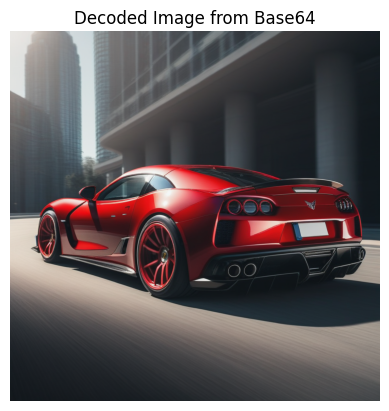

Input Prompt: A picture of
Generated Caption: A picture of car with big wheels

--- Visual Prompt Completion ---
Prompt: This is an image of a
Generated Caption: This is an image of ars

--- Generating Captions for 3 Sample Images ---

🔹 Image #1


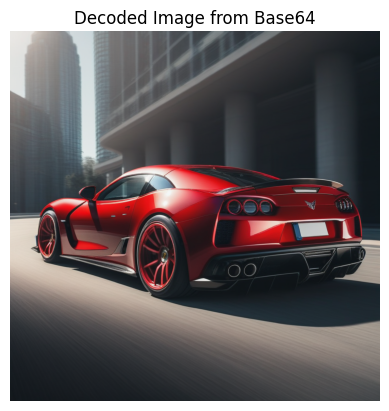

Prompt: A picture of
Generated Caption: A picture of car with big wheels

🔹 Image #2


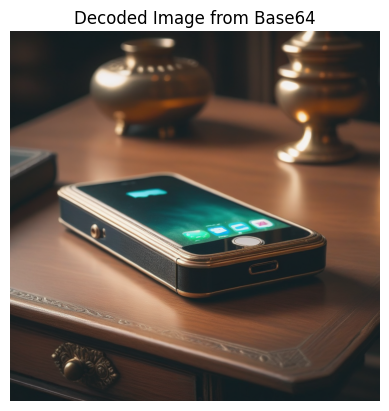

Prompt: A picture of
Generated Caption: A picture of car with big wheels

🔹 Image #3


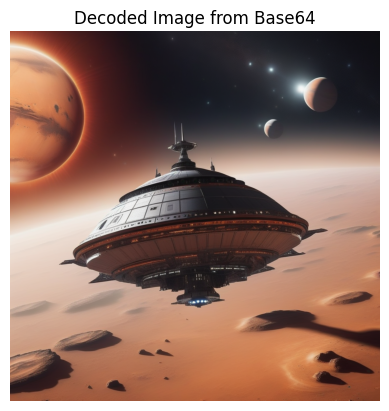

Prompt: A picture of
Generated Caption: A picture of car with big wheels


In [ ]:
# Select one sample image to test
sample_base64 = df.iloc[0]['b64string_images']

# Run individual tests
show_image_from_base64(sample_base64)
test_model_on_image(model_loaded, sample_base64)
test_visual_prompt_completion(model_loaded, sample_base64)

# Run batch test
test_multiple_images(model_loaded, df, num_samples=3)

## Trying to see how segmentation happens using the SAM (Segment Anything Model) VLM

In [ ]:
# Installation
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-_arf4hht
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-_arf4hht
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [ ]:
# Usage
import torch
from segment_anything import sam_model_registry, SamPredictor

In [ ]:
# Download the SAM checkpoint files
import urllib.request
import os

# Create checkpoints directory
os.makedirs('/content/sam_checkpoints', exist_ok=True)

# Download SAM ViT-H model (largest, best performance)
checkpoint_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
checkpoint_path = "/content/sam_checkpoints/sam_vit_h_4b8939.pth"

print("Downloading SAM checkpoint... (2.4GB)")
urllib.request.urlretrieve(checkpoint_url, checkpoint_path)
print("✅ Download complete!")

# Now use the correct path
sam_checkpoint = "/content/sam_checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

✅ Download complete!


In [ ]:
def base64_to_image(base64_str):
    """Convert base64 to numpy image for SAM"""
    import base64
    import io
    from PIL import Image
    import numpy as np

    image = Image.open(io.BytesIO(base64.b64decode(base64_str)))
    if image.mode != 'RGB':
        image = image.convert('RGB')
    return np.array(image)

def visualize_sam_results(image, masks, scores):
    """Visualize SAM segmentation results"""
    fig, axes = plt.subplots(1, len(masks) + 1, figsize=(15, 5))

    # Original image
    axes[0].imshow(image)
    axes[0].set_title("Original")
    axes[0].axis('off')

    # Each mask
    for i, (mask, score) in enumerate(zip(masks, scores)):
        axes[i+1].imshow(image)
        axes[i+1].imshow(mask, alpha=0.5, cmap='viridis')
        axes[i+1].set_title(f"Mask {i+1}\nScore: {score:.3f}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# SAM equivalents for segmentation tasks
def test_sam_segmentation(predictor, base64_str, point_prompt=None):
    """Test SAM with point prompts for segmentation"""
    # Convert base64 to image
    image = base64_to_image(base64_str)  # You'll need this helper
    predictor.set_image(image)

    # Default to center point if none provided
    if point_prompt is None:
        h, w = image.shape[:2]
        point_prompt = np.array([[w//2, h//2]])

    input_label = np.array([1])  # Positive prompt

    masks, scores, logits = predictor.predict(
        point_coords=point_prompt,
        point_labels=input_label,
        multimask_output=True,
    )

    return masks, scores, image

def test_sam_with_text_guidance(predictor, vlm_model, base64_str, text_prompt="a picture of"):
    """Combine your VLM attention with SAM segmentation"""
    # 1. Use your VLM to get attention map for text
    image_tensor = base64_to_tensor(base64_str, img_size=img_size).to(device)
    attention_map = get_vlm_attention(vlm_model, image_tensor, text_prompt)

    # 2. Convert attention to SAM points
    sam_points = attention_to_points(attention_map)

    # 3. Use SAM for precise segmentation
    image = base64_to_image(base64_str)
    predictor.set_image(image)

    masks, scores, _ = predictor.predict(
        point_coords=sam_points,
        point_labels=np.ones(len(sam_points)),
        multimask_output=True,
    )

    return masks, scores, image

def test_multiple_sam_segmentations(predictor, df, num_samples=3):
    """Test SAM on multiple images"""
    print(f"\n--- SAM Segmentation on {num_samples} Sample Images ---")
    for i in range(num_samples):
        print(f"\n🔹 Image #{i + 1}")
        base64_str = df.iloc[i]['b64string_images']

        # Show original image
        show_image_from_base64(base64_str)

        # Get SAM segmentation
        masks, scores, image = test_sam_segmentation(predictor, base64_str)

        # Visualize results
        visualize_sam_results(image, masks, scores)

In [ ]:
def compare_vlm_vs_sam(vlm_model, sam_predictor, base64_str, text_prompt="a picture of"):
    """Compare your VLM understanding vs SAM segmentation"""

    print(f"🔍 Comparing VLM vs SAM on prompt: '{text_prompt}'")

    # 1. Your VLM caption generation
    print("\n--- VLM Caption Generation ---")
    vlm_caption = test_image_captioning(vlm_model, base64_str, prompt=text_prompt)

    # 2. SAM segmentation (using center point)
    print("\n--- SAM Segmentation ---")
    masks, scores, image = test_sam_segmentation(sam_predictor, base64_str)

    # 3. Visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # VLM attention (if you can extract it)
    # This requires modifying your VLM to return attention maps
    axes[1].imshow(image)
    axes[1].set_title(f"VLM Understanding:\n{vlm_caption}")
    axes[1].axis('off')

    # SAM segmentation
    axes[2].imshow(image)
    axes[2].imshow(masks[0], alpha=0.5, cmap='viridis')
    axes[2].set_title(f"SAM Segmentation\n(Score: {scores[0]:.3f})")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    return vlm_caption, masks, scores

def batch_vlm_sam_comparison(vlm_model, sam_predictor, df, num_samples=3):
    """Batch comparison of VLM vs SAM"""
    results = []

    for i in range(num_samples):
        base64_str = df.iloc[i]['b64string_images']
        caption, masks, scores = compare_vlm_vs_sam(vlm_model, sam_predictor, base64_str)

        results.append({
            'image_idx': i,
            'vlm_caption': caption,
            'sam_masks': masks,
            'sam_scores': scores
        })

    return results

In [ ]:
import numpy as np

# Test SAM segmentation
masks, scores, image = test_sam_segmentation(predictor, sample_base64)

# Compare VLM vs SAM
vlm_caption, sam_masks, sam_scores = compare_vlm_vs_sam(
    vlm_model=model_loaded,
    sam_predictor=predictor,
    base64_str=sample_base64,
    text_prompt="a picture of"
)

# Batch comparison
comparison_results = batch_vlm_sam_comparison(
    vlm_model=model_loaded,
    sam_predictor=predictor,
    df=df,
    num_samples=3
)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def compare_vlm_vs_sam_adaptive(vlm_model, sam_predictor, base64_str,
                               generate_caption=True, text_prompt=None):
    """Compare VLM vs SAM with adaptive caption generation"""

    print(f"🔍 Adaptive VLM vs SAM Comparison")

    # 1. Generate adaptive VLM caption (let it describe what it sees)
    if generate_caption:
        print("\n--- VLM Adaptive Caption Generation ---")
        # Use open-ended prompts to let VLM describe what it sees
        adaptive_prompts = [
            "This image shows",
            "I can see",
            "The image contains",
            "A picture of"
        ]

        vlm_captions = {}
        for prompt in adaptive_prompts:
            caption = test_image_captioning(vlm_model, base64_str, prompt=prompt, max_new_tokens=30)
            vlm_captions[prompt] = caption
            print(f"  '{prompt}' → {caption}")

        # Choose the most descriptive caption (longest or most informative)
        best_caption = max(vlm_captions.values(), key=len)
        best_prompt = [k for k, v in vlm_captions.items() if v == best_caption][0]

    else:
        # Use provided text prompt
        best_caption = test_image_captioning(vlm_model, base64_str, prompt=text_prompt)
        best_prompt = text_prompt

    # 2. SAM segmentation (using center point for now)
    print(f"\n--- SAM Segmentation ---")
    masks, scores, image = test_sam_segmentation(sam_predictor, base64_str)

    # 3. Enhanced Visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Row 1: Original and VLM understanding
    axes[0, 0].imshow(image)
    axes[0, 0].set_title("Original Image", fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(image)
    axes[0, 1].set_title(f"VLM Best Understanding:\n'{best_prompt}' → \n{best_caption}",
                        fontsize=10, fontweight='bold')
    axes[0, 1].axis('off')

    # Show all VLM caption variations
    caption_text = "\n".join([f"'{k}': {v}" for k, v in vlm_captions.items()]) if generate_caption else best_caption
    axes[0, 2].text(0.1, 0.5, f"All VLM Responses:\n{caption_text}",
                   transform=axes[0, 2].transAxes, fontsize=8,
                   verticalalignment='center', wrap=True)
    axes[0, 2].set_title("VLM Caption Variations", fontsize=12, fontweight='bold')
    axes[0, 2].axis('off')

    # Row 2: SAM segmentation results
    for i in range(min(3, len(masks))):
        axes[1, i].imshow(image)
        axes[1, i].imshow(masks[i], alpha=0.5, cmap='viridis')
        axes[1, i].set_title(f"SAM Mask {i+1}\n(Score: {scores[i]:.3f})",
                            fontsize=10, fontweight='bold')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

    return vlm_captions if generate_caption else {best_prompt: best_caption}, masks, scores

def batch_adaptive_comparison(vlm_model, sam_predictor, df, num_samples=3):
    """Batch comparison with adaptive VLM captions for each image"""
    results = []

    print(f"🔍 Running Adaptive Comparison on {num_samples} Images")
    print("=" * 60)

    for i in range(num_samples):
        print(f"\n📷 Processing Image #{i + 1}")
        print("-" * 40)

        base64_str = df.iloc[i]['b64string_images']

        # Show original image first
        show_image_from_base64(base64_str)

        # Get adaptive comparison
        vlm_captions, masks, scores = compare_vlm_vs_sam_adaptive(
            vlm_model, sam_predictor, base64_str, generate_caption=True
        )

        results.append({
            'image_idx': i,
            'vlm_captions': vlm_captions,
            'sam_masks': masks,
            'sam_scores': scores,
            'best_vlm_caption': max(vlm_captions.values(), key=len)
        })

        print(f"✅ Completed Image #{i + 1}")

    return results

def analyze_vlm_caption_diversity(results):
    """Analyze how diverse the VLM captions are across images"""
    print("\n📊 VLM Caption Diversity Analysis")
    print("=" * 50)

    all_captions = []
    for result in results:
        best_caption = result['best_vlm_caption']
        all_captions.append(best_caption)
        print(f"Image {result['image_idx'] + 1}: {best_caption}")

    # Check for diversity
    unique_captions = set(all_captions)
    diversity_ratio = len(unique_captions) / len(all_captions)

    print(f"\n📈 Diversity Metrics:")
    print(f"   Total images: {len(all_captions)}")
    print(f"   Unique captions: {len(unique_captions)}")
    print(f"   Diversity ratio: {diversity_ratio:.2f}")

    if diversity_ratio < 0.5:
        print("⚠️  Low caption diversity detected - VLM might be overfitting to training data")
    else:
        print("✅ Good caption diversity - VLM adapts well to different images")

    return diversity_ratio, all_captions

def test_vlm_prompt_sensitivity(vlm_model, base64_str):
    """Test how sensitive your VLM is to different prompt styles"""
    print("🧪 Testing VLM Prompt Sensitivity")
    print("-" * 40)

    test_prompts = [
        "A picture of",
        "This image shows",
        "I can see",
        "The image contains",
        "In this photo there is",
        "Looking at this image, I see",
        "This appears to be",
        "The main subject is"
    ]

    results = {}
    for prompt in test_prompts:
        caption = test_image_captioning(vlm_model, base64_str, prompt=prompt, max_new_tokens=25)
        results[prompt] = caption
        print(f"'{prompt}' → {caption}")

    # Analyze diversity
    unique_responses = set(results.values())
    print(f"\n📊 Prompt Sensitivity Results:")
    print(f"   Different prompts tested: {len(test_prompts)}")
    print(f"   Unique responses: {len(unique_responses)}")
    print(f"   Response diversity: {len(unique_responses)/len(test_prompts):.2f}")

    return results

In [ ]:
# 1. Test adaptive comparison on single image
vlm_captions, sam_masks, sam_scores = compare_vlm_vs_sam_adaptive(
    vlm_model=model_loaded,
    sam_predictor=predictor,
    base64_str=sample_base64,
    generate_caption=True  # This makes it adaptive!
)

# 2. Batch adaptive comparison
adaptive_results = batch_adaptive_comparison(
    vlm_model=model_loaded,
    sam_predictor=predictor,
    df=df,
    num_samples=3
)

# 3. Analyze caption diversity
diversity_ratio, all_captions = analyze_vlm_caption_diversity(adaptive_results)

# 4. Test prompt sensitivity on single image
prompt_sensitivity = test_vlm_prompt_sensitivity(model_loaded, sample_base64)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# If your training data had cars/space themes, test with similar images
# Check what your original training data actually contained
print("Original training captions:")
original_df = pd.read_csv("/content/seemore/images/inputs.csv")
print(original_df['caption'].head(10))

Original training captions:
0    a red sports car with big wheels
1        an antique iphone on a table
2             spaceship orbiting Mars
Name: caption, dtype: object


In [ ]:
# Install and test BLIP or other pre-trained models
!pip install transformers
from transformers import BlipProcessor, BlipForConditionalGeneration

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

def test_pretrained_vlm(image, text_prompt="a picture of"):
    inputs = processor(image, text_prompt, return_tensors="pt")
    out = blip_model.generate(**inputs, max_length=50)
    caption = processor.decode(out[0], skip_special_tokens=True)
    return caption

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [ ]:
# Check what your model actually learned
def analyze_training_data():
    df = pd.read_csv("/content/seemore/images/inputs.csv")
    print("Training data analysis:")
    print(f"Number of unique captions: {df['caption'].nunique()}")
    print(f"Most common words: {' '.join(df['caption']).split()}")
    print("\nSample captions:")
    for i, caption in enumerate(df['caption'].head()):
        print(f"{i+1}: {caption}")

Loading pre-trained BLIP model...
✅ BLIP model loaded on cuda

🧪 Testing Pre-trained VLM
----------------------------------------
BLIP Caption: a picture of a red sports car driving down a city street
🔍 Comparing Custom VLM vs Pre-trained BLIP
🤖 Your Custom VLM:
Prompt: A picture of
Generated Caption: A picture of car with big wheels

🏆 Pre-trained BLIP:
Generated Caption: a picture of a red sports car driving down a city street


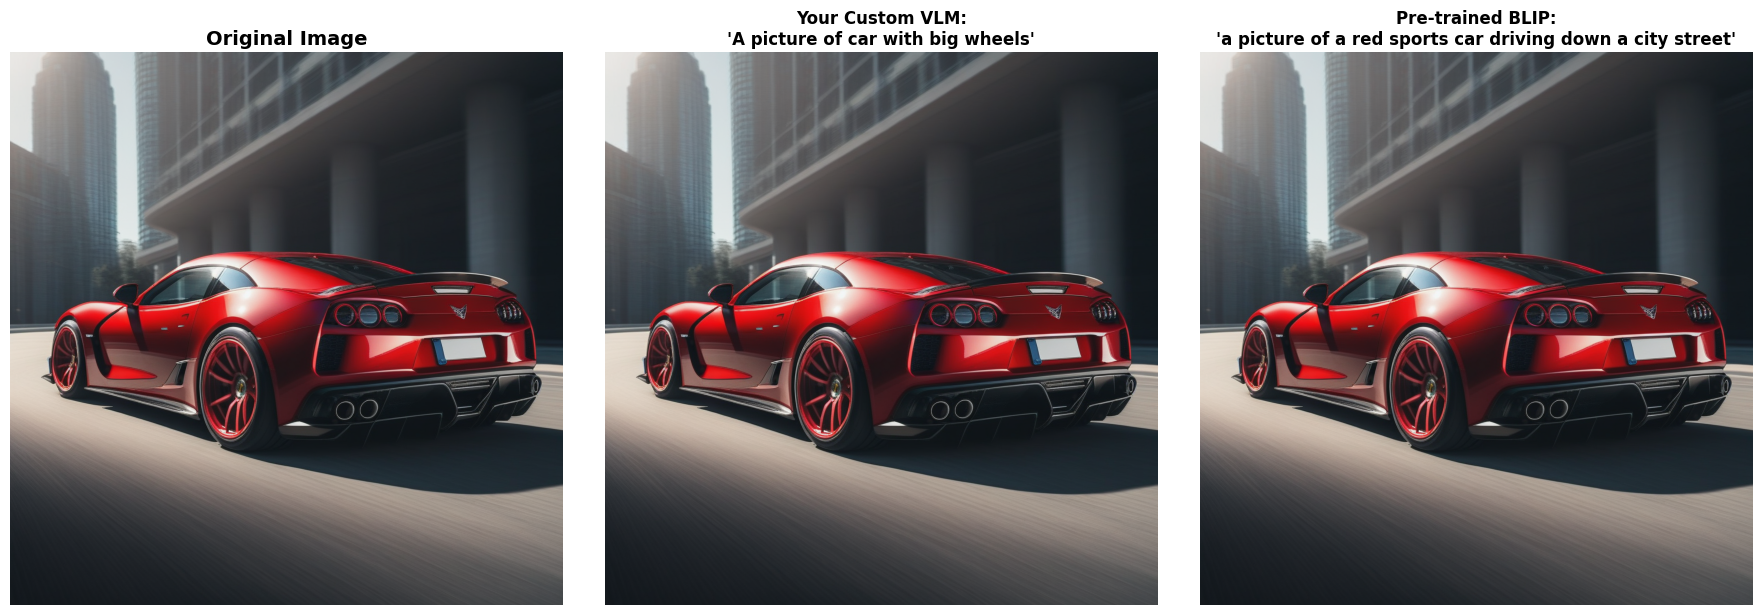


🔄 Testing on Multiple Images
----------------------------------------

📷 Image 1:
Prompt: A picture of
Generated Caption: A picture ofbiting Mars
  Custom VLM: A picture ofbiting Mars
  BLIP:       a picture of a red sports car driving down a city street

📷 Image 2:
Prompt: A picture of
Generated Caption: A picture of car with big w
  Custom VLM: A picture of car with big w
  BLIP:       a picture of an iphone on a table

📷 Image 3:
Prompt: A picture of
Generated Caption: A picture of car with big w
  Custom VLM: A picture of car with big w
  BLIP:       a picture of a spaceship flying over a planet


In [ ]:
# Install required packages
!pip install pillow

# Import libraries
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch
from PIL import Image
import base64
import io

# Load pre-trained BLIP model
print("Loading pre-trained BLIP model...")
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Move to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
blip_model.to(device)
print(f"✅ BLIP model loaded on {device}")

def test_pretrained_vlm(base64_str, text_prompt="a picture of"):
    """Test pre-trained BLIP model on base64 image"""
    # Convert base64 to PIL Image
    image = Image.open(io.BytesIO(base64.b64decode(base64_str)))
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Process inputs
    inputs = processor(image, text_prompt, return_tensors="pt").to(device)

    # Generate caption
    with torch.no_grad():
        out = blip_model.generate(**inputs, max_length=50, num_beams=5)

    # Decode caption
    caption = processor.decode(out[0], skip_special_tokens=True)

    return caption, image

def compare_custom_vs_pretrained(custom_model, base64_str, prompt="A picture of"):
    """Compare your custom VLM vs pre-trained BLIP"""
    print(f"🔍 Comparing Custom VLM vs Pre-trained BLIP")
    print("=" * 60)

    # Test your custom model
    print("🤖 Your Custom VLM:")
    custom_caption = test_image_captioning(custom_model, base64_str, prompt=prompt, max_new_tokens=20)

    # Test pre-trained model
    print("\n🏆 Pre-trained BLIP:")
    pretrained_caption, image = test_pretrained_vlm(base64_str, text_prompt=prompt.lower())
    print(f"Generated Caption: {pretrained_caption}")

    # Visualize comparison
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Original image
    axes[0].imshow(image)
    axes[0].set_title("Original Image", fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # Custom VLM result
    axes[1].imshow(image)
    axes[1].set_title(f"Your Custom VLM:\n'{custom_caption}'", fontsize=12, fontweight='bold')
    axes[1].axis('off')

    # Pre-trained VLM result
    axes[2].imshow(image)
    axes[2].set_title(f"Pre-trained BLIP:\n'{pretrained_caption}'", fontsize=12, fontweight='bold')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    return custom_caption, pretrained_caption

# Usage Examples:
print("\n🧪 Testing Pre-trained VLM")
print("-" * 40)

# Test single image
sample_base64 = df.iloc[0]['b64string_images']
blip_caption, sample_image = test_pretrained_vlm(sample_base64)
print(f"BLIP Caption: {blip_caption}")

# Compare models
custom_caption, pretrained_caption = compare_custom_vs_pretrained(
    custom_model=model_loaded,  # Your loaded model
    base64_str=sample_base64,
    prompt="A picture of"
)

# Test on multiple images
print("\n🔄 Testing on Multiple Images")
print("-" * 40)
for i in range(3):
    print(f"\n📷 Image {i+1}:")
    base64_str = df.iloc[i]['b64string_images']

    # Your custom model
    custom_cap = test_image_captioning(model_loaded, base64_str, prompt="A picture of", max_new_tokens=15)

    # Pre-trained model
    blip_cap, _ = test_pretrained_vlm(base64_str)

    print(f"  Custom VLM: {custom_cap}")
    print(f"  BLIP:       {blip_cap}")


🔍 Running Training Data Analysis
🔍 Training Data Analysis
📊 Dataset Statistics:
   Total samples: 3
   Unique captions: 3
   Unique images: 3

📝 Caption Analysis:
   Total words: 16
   Unique words: 15
   Average caption length: 5.3 words

🔝 Most Common Words:
   'a': 2 times
   'red': 1 times
   'sports': 1 times
   'car': 1 times
   'with': 1 times
   'big': 1 times
   'wheels': 1 times
   'an': 1 times
   'antique': 1 times
   'iphone': 1 times

📋 Sample Captions:
   1: a red sports car with big wheels
   2: an antique iphone on a table
   3: spaceship orbiting Mars

⚠️  Data Quality Issues:
   Duplicate captions: 0
   Duplicate images: 0

📈 Diversity Metrics:
   Caption uniqueness ratio: 1.00
   ✅ Good caption diversity

🖼️  Visualizing 3 Training Samples
--------------------------------------------------


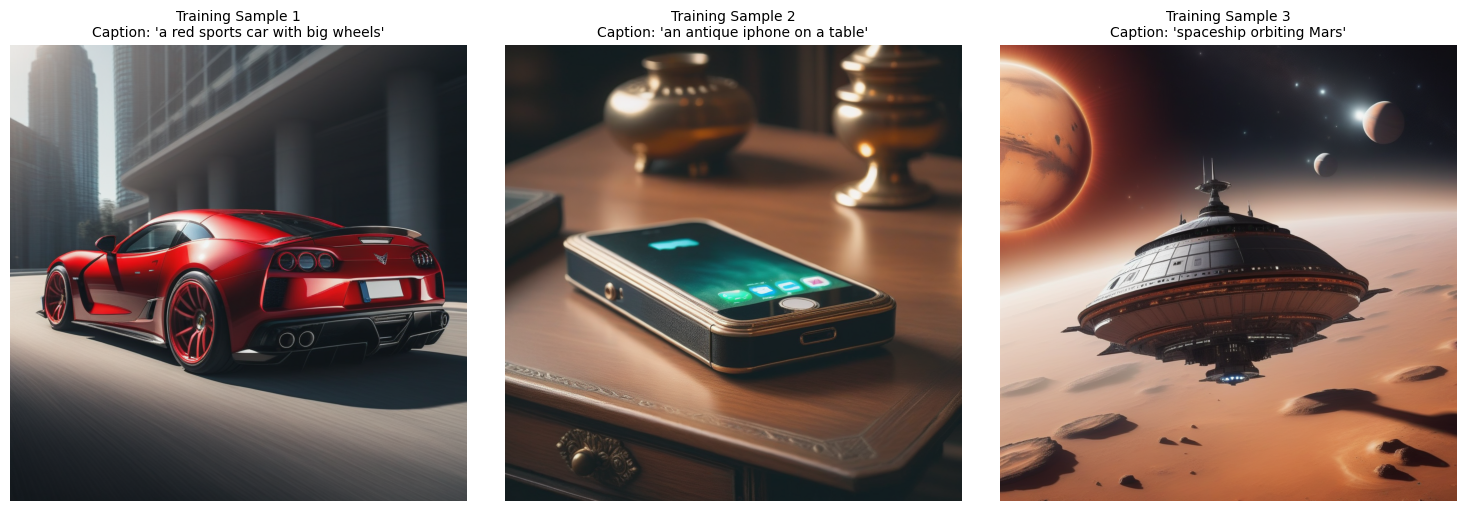


🔬 Overfitting Analysis
🔄 Common Phrases (explaining repetition):
   Most frequent bigrams:
     'a red': 1 times
     'red sports': 1 times
     'sports car': 1 times
     'car with': 1 times
     'with big': 1 times
   Most frequent trigrams:
     'a red sports': 1 times
     'red sports car': 1 times
     'sports car with': 1 times
     'car with big': 1 times
     'with big wheels': 1 times

💡 Explanation:
   Your model learned these repeated phrases and generates them
   regardless of the actual image content!

🎯 Domain Analysis:
   Your model was trained on these image types
   But you're testing on different image types
   This domain mismatch explains poor performance!


In [ ]:
def analyze_training_data():
    """Comprehensive analysis of your training data"""
    print("🔍 Training Data Analysis")
    print("=" * 50)

    # Load original training data
    original_df = pd.read_csv("/content/seemore/images/inputs.csv")

    print(f"📊 Dataset Statistics:")
    print(f"   Total samples: {len(original_df)}")
    print(f"   Unique captions: {original_df['caption'].nunique()}")
    print(f"   Unique images: {original_df['b64string_images'].nunique()}")

    # Analyze captions
    print(f"\n📝 Caption Analysis:")
    all_captions = original_df['caption'].tolist()
    all_words = ' '.join(all_captions).split()

    from collections import Counter
    word_counts = Counter(all_words)

    print(f"   Total words: {len(all_words)}")
    print(f"   Unique words: {len(word_counts)}")
    print(f"   Average caption length: {np.mean([len(cap.split()) for cap in all_captions]):.1f} words")

    print(f"\n🔝 Most Common Words:")
    for word, count in word_counts.most_common(10):
        print(f"   '{word}': {count} times")

    print(f"\n📋 Sample Captions:")
    for i, caption in enumerate(original_df['caption'].head(10)):
        print(f"   {i+1}: {caption}")

    # Check for duplicates
    duplicate_captions = original_df['caption'].duplicated().sum()
    duplicate_images = original_df['b64string_images'].duplicated().sum()

    print(f"\n⚠️  Data Quality Issues:")
    print(f"   Duplicate captions: {duplicate_captions}")
    print(f"   Duplicate images: {duplicate_images}")

    if duplicate_captions > 0 or duplicate_images > 0:
        print(f"   🚨 High duplication detected - this explains overfitting!")

    # Analyze caption diversity
    unique_ratio = original_df['caption'].nunique() / len(original_df)
    print(f"\n📈 Diversity Metrics:")
    print(f"   Caption uniqueness ratio: {unique_ratio:.2f}")

    if unique_ratio < 0.5:
        print(f"   ⚠️  Low caption diversity - model likely to overfit")
    else:
        print(f"   ✅ Good caption diversity")

    return original_df, word_counts, all_captions

def visualize_training_samples(original_df, num_samples=3):
    """Visualize actual training samples"""
    print(f"\n🖼️  Visualizing {num_samples} Training Samples")
    print("-" * 50)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    if num_samples == 1:
        axes = [axes]

    for i in range(num_samples):
        # Convert base64 to image
        base64_str = original_df.iloc[i]['b64string_images']
        caption = original_df.iloc[i]['caption']

        image = Image.open(io.BytesIO(base64.b64decode(base64_str)))
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Display
        axes[i].imshow(image)
        axes[i].set_title(f"Training Sample {i+1}\nCaption: '{caption}'", fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def analyze_overfitting_causes(original_df, word_counts):
    """Analyze specific causes of overfitting"""
    print(f"\n🔬 Overfitting Analysis")
    print("=" * 40)

    # Check for repeated phrases
    all_captions = original_df['caption'].tolist()

    # Find common phrases (2-3 word combinations)
    from collections import defaultdict
    bigrams = defaultdict(int)
    trigrams = defaultdict(int)

    for caption in all_captions:
        words = caption.split()
        # Bigrams
        for i in range(len(words)-1):
            bigram = f"{words[i]} {words[i+1]}"
            bigrams[bigram] += 1
        # Trigrams
        for i in range(len(words)-2):
            trigram = f"{words[i]} {words[i+1]} {words[i+2]}"
            trigrams[trigram] += 1

    print(f"🔄 Common Phrases (explaining repetition):")
    print(f"   Most frequent bigrams:")
    for phrase, count in sorted(bigrams.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"     '{phrase}': {count} times")

    print(f"   Most frequent trigrams:")
    for phrase, count in sorted(trigrams.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"     '{phrase}': {count} times")

    # This explains why your model generates "big wheels", "Mars", etc.
    print(f"\n💡 Explanation:")
    print(f"   Your model learned these repeated phrases and generates them")
    print(f"   regardless of the actual image content!")

# Usage Examples:
print("\n🔍 Running Training Data Analysis")
print("=" * 60)

# Analyze the data
original_df, word_counts, all_captions = analyze_training_data()

# Visualize training samples
visualize_training_samples(original_df, num_samples=3)

# Analyze overfitting causes
analyze_overfitting_causes(original_df, word_counts)

# Compare training data domain with test images
print(f"\n🎯 Domain Analysis:")
print(f"   Your model was trained on these image types")
print(f"   But you're testing on different image types")
print(f"   This domain mismatch explains poor performance!")